# Problem Statement:

#### Data contains statements which describes what made them happy. Based on the statement, predict the category of happiness. The categories given are:

 - Achievent
 - Affection
 - Bonding
 - Enjoy the moment
 - Exercise
 - Leisure
 - Nature

## Step-wise approach:

 1. Importing required libraries and data
 2. Understanding the data
 3. Data Cleaning
 4. Exploratory Data analysis
 5. Text cleaning
 6. Data preparation for modelling
 7. Finiding best model using grid search
 8. Predicting on test dataset
 9. Exporting CSV

## Step-1: Importing libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
import collections
pd.set_option('display.max_column',100)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [2]:
df = pd.read_csv('hm_train.csv')
df.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,affection
1,27674,24h,I was happy when my son got 90% marks in his e...,1,affection
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise
3,27676,24h,We had a serious talk with some friends of our...,2,bonding
4,27677,24h,I went with grandchildren to butterfly display...,1,affection


## Step-2: Understanding the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60321 entries, 0 to 60320
Data columns (total 5 columns):
hmid                  60321 non-null int64
reflection_period     60321 non-null object
cleaned_hm            60321 non-null object
num_sentence          60321 non-null int64
predicted_category    60321 non-null object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [4]:
df.isnull().sum()

hmid                  0
reflection_period     0
cleaned_hm            0
num_sentence          0
predicted_category    0
dtype: int64

#### No missing data

## Step-3: Data cleaning

In [5]:
df['reflection_period'].value_counts()

24h    30455
3m     29866
Name: reflection_period, dtype: int64

#### Convert it into categorical variable
 - 24h as 'Whole Day'
 - 3m as 'Short Term'

In [6]:
df['reflection_period']=df['reflection_period'].replace('24h','Whole Day')
df['reflection_period']=df['reflection_period'].replace('3m','Short Term')

In [7]:
df['reflection_period'].value_counts()

Whole Day     30455
Short Term    29866
Name: reflection_period, dtype: int64

In [8]:
df['predicted_category'].value_counts()

affection           20880
achievement         20274
bonding              6561
enjoy_the_moment     6508
leisure              4242
nature               1127
exercise              729
Name: predicted_category, dtype: int64

## Step-4: EDA

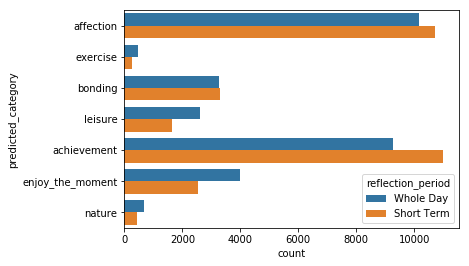

<Figure size 1440x1080 with 0 Axes>

In [9]:
sns.countplot(y=df['predicted_category'], hue=df['reflection_period'])
plt.figure(figsize=(20,15))
plt.show()

#### The class variables is imbalanced. We can balance by up or undersampling

#### In Leisure, Achievement and Enjoy the moment classes there is a significant difference in reflection period.
#### Happiness reflects for longer time with leisure, achievement and enjoy the moment.

### Text analysis

In [10]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, statement):
        return len(re.findall(pattern, statement))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x : self.count_regex(r'\w+', x))
        count_capital_words = X.apply(lambda x : self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_exclam_question_mark = X.apply(lambda x: self.count_regex(r'!|\?', x))
        
        df = pd.DataFrame({'count_words':count_words,
                          'count_capital_words': count_capital_words,
                          'count_exclam_question_mark': count_exclam_question_mark
                          })
        
        return df

In [11]:
tc = TextCounts()
df_text = tc.fit_transform(df['cleaned_hm'])
df_text.head()

,count_words,count_capital_words,count_exclam_question_mark
0,14,0,0
1,12,0,0
2,10,0,0
3,25,0,0
4,10,0,0


In [12]:
df_text['Statement'] = df['cleaned_hm']
df_text.head()

,count_words,count_capital_words,count_exclam_question_mark,Statement
0,14,0,0,I went on a successful date with someone I fel...
1,12,0,0,I was happy when my son got 90% marks in his e...
2,10,0,0,I went to the gym this morning and did yoga.
3,25,0,0,We had a serious talk with some friends of our...
4,10,0,0,I went with grandchildren to butterfly display...


In [13]:
df[['count_words', 'count_capital_words','count_exclam_question_mark']] = df_text[['count_words', 'count_capital_words','count_exclam_question_mark']]
df.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category,count_words,count_capital_words,count_exclam_question_mark
0,27673,Whole Day,I went on a successful date with someone I fel...,1,affection,14,0,0
1,27674,Whole Day,I was happy when my son got 90% marks in his e...,1,affection,12,0,0
2,27675,Whole Day,I went to the gym this morning and did yoga.,1,exercise,10,0,0
3,27676,Whole Day,We had a serious talk with some friends of our...,2,bonding,25,0,0
4,27677,Whole Day,I went with grandchildren to butterfly display...,1,affection,10,0,0


In [14]:
def descriptive_stat(dat, col):
    print(dat.groupby('predicted_category')[col].describe())
    ay = sns.barplot(x= dat['predicted_category'].unique(), y=dat.groupby('predicted_category')[col].mean().sort_values(ascending=False), palette='Blues_r') 
    ay.set_xticklabels(ay.get_xticklabels(), rotation=90)
    plt.show()

                      count       mean        std  min   25%   50%   75%  \
predicted_category                                                         
achievement         20274.0  16.846602  14.073717  1.0   9.0  13.0  20.0   
affection           20880.0  21.444492  27.114832  2.0  10.0  15.0  24.0   
bonding              6561.0  19.553269  20.651786  1.0  10.0  15.0  22.0   
enjoy_the_moment     6508.0  21.669176  27.644116  2.0   9.0  14.5  24.0   
exercise              729.0  13.500686   9.835896  2.0   7.0  11.0  16.0   
leisure              4242.0  12.463932   9.299885  1.0   7.0  10.0  15.0   
nature               1127.0  18.718722  14.834667  2.0  10.0  15.0  21.0   

                       max  
predicted_category          
achievement          343.0  
affection           1194.0  
bonding              480.0  
enjoy_the_moment     910.0  
exercise              91.0  
leisure              152.0  
nature               170.0  


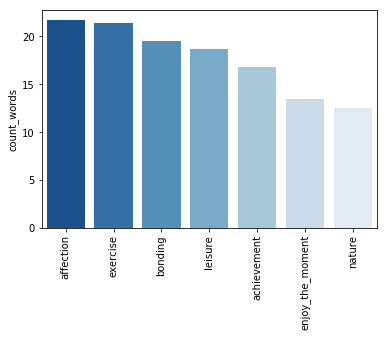

In [15]:
descriptive_stat(df, 'count_words')

                      count      mean       std  min  25%  50%  75%    max
predicted_category                                                        
achievement         20274.0  0.188468  1.736486  0.0  0.0  0.0  0.0   93.0
affection           20880.0  0.394157  3.218916  0.0  0.0  0.0  0.0  105.0
bonding              6561.0  0.517299  3.542819  0.0  0.0  0.0  0.0  132.0
enjoy_the_moment     6508.0  0.304702  2.549669  0.0  0.0  0.0  0.0   72.0
exercise              729.0  0.090535  0.497279  0.0  0.0  0.0  0.0    4.0
leisure              4242.0  0.390382  1.447626  0.0  0.0  0.0  0.0   29.0
nature               1127.0  0.182786  2.456793  0.0  0.0  0.0  0.0   69.0


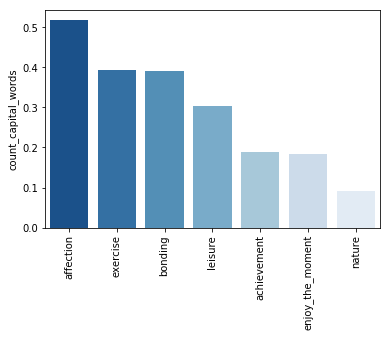

In [16]:
descriptive_stat(df, 'count_capital_words')

                      count      mean       std  min  25%  50%  75%   max
predicted_category                                                       
achievement         20274.0  0.059633  0.299698  0.0  0.0  0.0  0.0  11.0
affection           20880.0  0.056944  0.322481  0.0  0.0  0.0  0.0  11.0
bonding              6561.0  0.036885  0.252147  0.0  0.0  0.0  0.0   7.0
enjoy_the_moment     6508.0  0.072372  0.334234  0.0  0.0  0.0  0.0   8.0
exercise              729.0  0.043896  0.247502  0.0  0.0  0.0  0.0   3.0
leisure              4242.0  0.040075  0.259317  0.0  0.0  0.0  0.0   9.0
nature               1127.0  0.066548  0.279572  0.0  0.0  0.0  0.0   3.0


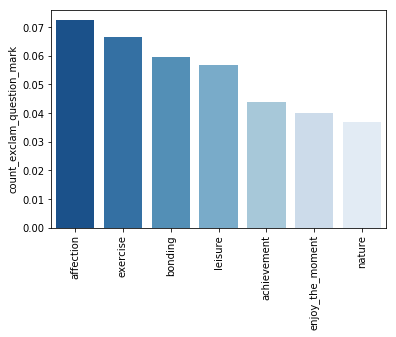

In [17]:
descriptive_stat(df, 'count_exclam_question_mark')

                      count      mean       std  min  25%  50%  75%   max
predicted_category                                                       
achievement         20274.0  1.233945  0.791342  1.0  1.0  1.0  1.0  21.0
affection           20880.0  1.474713  1.686058  1.0  1.0  1.0  1.0  58.0
bonding              6561.0  1.363664  1.197323  1.0  1.0  1.0  1.0  29.0
enjoy_the_moment     6508.0  1.529502  1.671654  1.0  1.0  1.0  1.0  46.0
exercise              729.0  1.144033  0.471548  1.0  1.0  1.0  1.0   5.0
leisure              4242.0  1.113390  0.463845  1.0  1.0  1.0  1.0  10.0
nature               1127.0  1.353150  1.129865  1.0  1.0  1.0  1.0  18.0


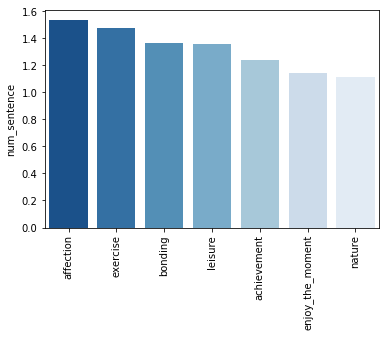

In [18]:
descriptive_stat(df, 'num_sentence')

#### Affection has the higest number of words, capital letters, exclamatory marks and number of sentences while nature has the least when their average is compared

## Step-5: Cleaning text

 - Remove punctuations
 - Remove digits
 - Convert to lower case
 - Remove stopwords
 - Stem the words

In [19]:
class TextClean( BaseEstimator, TransformerMixin):
    
    def remove_punc(self, text):
        punct = string.punctuation
        translation_table = str.maketrans(punct, len(punct)*' ')
        return text.translate(translation_table)
    
    def remove_digits(self, text):
        return re.sub('\d+', '', text)
    
    def to_lower(self, text):
        return text.lower()
    
    def remove_stopwords(self, text):
        sw_list = stopwords.words('english')
        words = text.split()
        clean_words = [word for word in words if word not in sw_list and len(word)>1]
        return ' '.join(clean_words)
    
    def stemming(self, text):
        porter = PorterStemmer()
        words = text.split()
        stemmed = [porter.stem(word) for word in words]
        return ' '.join(stemmed)
    
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        Clean_text = X.apply(self.remove_punc).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return Clean_text

In [20]:
tclean = TextClean()
df_text['Statement'] = tclean.fit_transform(df_text['Statement'])
df_text.head()

,count_words,count_capital_words,count_exclam_question_mark,Statement
0,14,0,0,went success date someon felt sympathi connect
1,12,0,0,happi son got mark examin
2,10,0,0,went gym morn yoga
3,25,0,0,seriou talk friend flaki late understood good ...
4,10,0,0,went grandchildren butterfli display crohn con...


In [21]:
#Check number of empty statement 
(df_text['Statement'] == '').sum()

1

In [22]:
#Impute 'no statement'
df_text['Statement'][df_text['Statement'] == ''] = '[no_statement]'

C:\Users\aniru\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Frequency of words

In [23]:
#Frequency of words
cv = CountVectorizer()
state = cv.fit_transform(df_text['Statement'])
word_frequency = dict(zip(cv.get_feature_names(), np.asarray(state.sum(axis=0)).ravel()))
word_df = pd.DataFrame(collections.Counter(word_frequency).most_common(25), columns=['word', 'frequency'])

In [24]:
word_df

,word,frequency
0,happi,12869
1,got,8107
2,made,7219
3,friend,6761
4,work,6036
5,went,5992
6,time,5929
7,day,5729
8,new,5217
9,get,3929


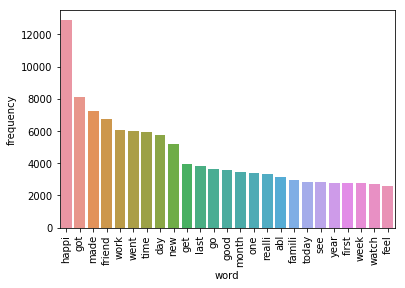

<Figure size 1080x720 with 0 Axes>

In [25]:
ax = sns.barplot(x='word', y='frequency', data=word_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.figure(figsize=(15,10))
plt.show()

#### Happy is the most frequently occuring word

In [26]:
df_text['category'] = df['predicted_category']
df_text['number of sentence'] = df['num_sentence']
df_text['reflection_period'] = df['reflection_period']
df_text = pd.get_dummies(df_text, columns=['reflection_period'], drop_first=True)
df_text.head()

,count_words,count_capital_words,count_exclam_question_mark,Statement,category,number of sentence,reflection_period_Whole Day
0,14,0,0,went success date someon felt sympathi connect,affection,1,1
1,12,0,0,happi son got mark examin,affection,1,1
2,10,0,0,went gym morn yoga,exercise,1,1
3,25,0,0,seriou talk friend flaki late understood good ...,bonding,2,1
4,10,0,0,went grandchildren butterfli display crohn con...,affection,1,1


## Step-6: Preparing data for modelling

### Outliers

In [27]:
num = ['count_words','count_capital_words','count_exclam_question_mark', 'number of sentence']

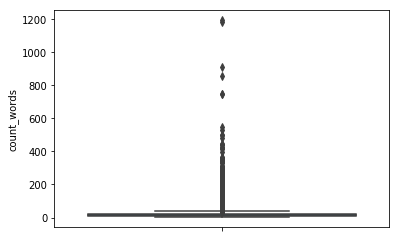

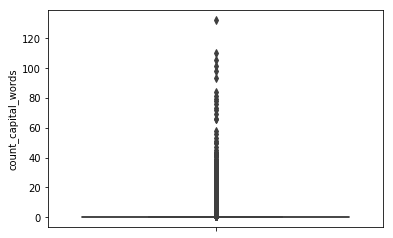

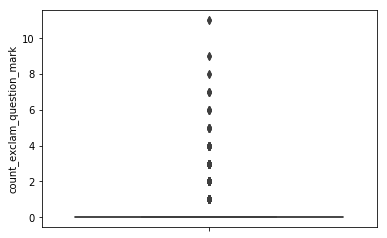

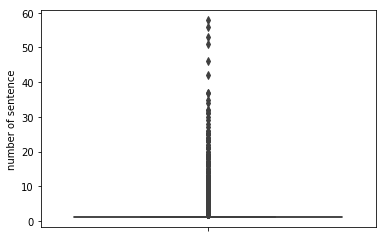

In [28]:
#Check for outliers
for var in num:
    sns.boxplot(y=var, data=df_text)
    plt.show()

#### There are outliers present. But we shall not remove it because bigger statements or statements with more exclamatory marks might be important to identify the emotion

### Spliting into test and train dataset

In [29]:
train, test = train_test_split(df_text, train_size = 0.7, test_size = 0.3, random_state = 100)

In [30]:
print(train.shape)
print(test.shape)

(42224, 7)
(18097, 7)


In [31]:
y_train = train.pop('category')
y_train.head()

19319    achievement
43215        bonding
28340      affection
42464      affection
13139    achievement
Name: category, dtype: object

In [32]:
X_train = train
X_train.head()

,count_words,count_capital_words,count_exclam_question_mark,Statement,number of sentence,reflection_period_Whole Day
19319,10,0,0,stay late work yesterday,1,1
43215,35,0,0,day work help someon walk comput drop paper he...,2,0
28340,14,0,0,kid went park play picnic,1,1
42464,14,0,0,happi cousin gave birth beauti girl child,1,0
13139,11,0,0,made destin car safe quickli,1,1


In [33]:
y_test = test.pop('category')
y_test.head()

13654        bonding
51314    achievement
11956      affection
53507    achievement
17800      affection
Name: category, dtype: object

In [34]:
X_test = test
X_test.head()

,count_words,count_capital_words,count_exclam_question_mark,Statement,number of sentence,reflection_period_Whole Day
13654,17,0,0,today afternoon went restaur lunch colleagu ni...,2,1
51314,16,0,0,figur answer logist problem bug month,1,0
11956,17,0,0,receiv aunt railway station brought home stay us,1,1
53507,19,0,0,day actual abl get complet entir list thing,1,0
17800,6,0,0,spent time parent today,1,1


## Step-7: Modelling using Grid Search

### Finding the best model using grid search 

### Lets use countvectorizer and logistic regression classifier

In [35]:
textstat_col = ['count_words','count_capital_words','count_exclam_question_mark','number of sentence','reflection_period_Whole Day']

In [36]:
#To extract columns from the dataframe
class ColumnExtractor(TransformerMixin, BaseEstimator):
    
    def __init__(self, cols):
        self.cols = cols
        
    def transform(self, X, **transform_params):
        return X[self.cols]
    
    def fit(self, X, y=None, **fit_params):
        return self 

#### Feature union applies a list of transformer objects in parallel to the input data, then concatenates the results. This is useful to combine several feature extraction mechanisms into a single transformer.

In [37]:
features = FeatureUnion([('textcount',ColumnExtractor(cols=textstat_col)),
                        ('pipe', Pipeline([('Clean Statement',ColumnExtractor(cols='Statement')),
                                           ('vect',CountVectorizer())]))],
                       n_jobs=-1)

In [38]:
pipeline = Pipeline([('features', features),
                    ('clf',LogisticRegression())])

In [39]:
parameters = {'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
              'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
              'features__pipe__vect__min_df': (1,2),
              'clf__C': (0.25, 0.5, 1.0),
              'clf__penalty': ('l1', 'l2')
             }

In [40]:
grid_search = GridSearchCV(pipeline, parameters, cv=5, verbose=1, n_jobs=-1)

In [41]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 39.5min finished
C:\Users\aniru\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aniru\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=-1,
       transformer_list=[('textcount', ColumnExtractor(cols=['count_words', 'count_capital_words', 'count_exclam_question_mark', 'number of sentence', 'reflection_period_Whole Day'])), ('pipe', Pipeline(memory=None,
     steps=[('Clean Statement', ColumnEx...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [42]:
#Best CV score
grid_search.best_score_

0.8863442591890868

In [43]:
#Best parameters
for name in parameters.keys():
    print(name, grid_search.best_estimator_.get_params()[name] )

features__pipe__vect__max_df 0.25
features__pipe__vect__ngram_range (1, 2)
features__pipe__vect__min_df 2
clf__C 1.0
clf__penalty l2


In [44]:
#Test score 
grid_search.best_estimator_.score(X_test, y_test)

0.895452284909101

In [45]:
#Precision, Recall
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

                  precision    recall  f1-score   support

     achievement       0.88      0.93      0.90      6157
       affection       0.94      0.95      0.94      6172
         bonding       0.94      0.95      0.94      2009
enjoy_the_moment       0.80      0.71      0.75      1904
        exercise       0.86      0.78      0.81       209
         leisure       0.83      0.77      0.80      1298
          nature       0.82      0.71      0.76       348

       micro avg       0.90      0.90      0.90     18097
       macro avg       0.87      0.83      0.84     18097
    weighted avg       0.89      0.90      0.89     18097



## Step-8: Predicting on test data

### Prepare the test data similar to train data

In [46]:
pred = pd.read_csv('hm_test.csv')
pred.head()

,hmid,reflection_period,cleaned_hm,num_sentence
0,88305,3m,I spent the weekend in Chicago with my friends.,1
1,88306,3m,We moved back into our house after a remodel. ...,2
2,88307,3m,My fiance proposed to me in front of my family...,1
3,88308,3m,I ate lobster at a fancy restaurant with some ...,1
4,88309,3m,I went out to a nice restaurant on a date with...,5


In [47]:
pred['reflection_period']=pred['reflection_period'].replace('24h','Whole Day')
pred['reflection_period']=pred['reflection_period'].replace('3m','Short Term')
pred.head()

,hmid,reflection_period,cleaned_hm,num_sentence
0,88305,Short Term,I spent the weekend in Chicago with my friends.,1
1,88306,Short Term,We moved back into our house after a remodel. ...,2
2,88307,Short Term,My fiance proposed to me in front of my family...,1
3,88308,Short Term,I ate lobster at a fancy restaurant with some ...,1
4,88309,Short Term,I went out to a nice restaurant on a date with...,5


In [48]:
pred_mod = tc.transform(pred['cleaned_hm'])
pred_mod.head()

,count_words,count_capital_words,count_exclam_question_mark
0,9,0,0
1,28,0,0
2,15,0,0
3,10,0,0
4,72,0,2


In [49]:
pred_mod[['reflection_period','number of sentence','Statement']] = pred[['reflection_period','num_sentence','cleaned_hm']]
pred_mod.head()

,count_words,count_capital_words,count_exclam_question_mark,reflection_period,number of sentence,Statement
0,9,0,0,Short Term,1,I spent the weekend in Chicago with my friends.
1,28,0,0,Short Term,2,We moved back into our house after a remodel. ...
2,15,0,0,Short Term,1,My fiance proposed to me in front of my family...
3,10,0,0,Short Term,1,I ate lobster at a fancy restaurant with some ...
4,72,0,2,Short Term,5,I went out to a nice restaurant on a date with...


In [50]:
pred_mod['Statement'] = tclean.transform(pred_mod['Statement'])
pred_mod.head()

,count_words,count_capital_words,count_exclam_question_mark,reflection_period,number of sentence,Statement
0,9,0,0,Short Term,1,spent weekend chicago friend
1,28,0,0,Short Term,2,move back hous remodel live hotel month due ho...
2,15,0,0,Short Term,1,fianc propos front famili begin march
3,10,0,0,Short Term,1,ate lobster fanci restaur friend
4,72,0,2,Short Term,5,went nice restaur date wife popular restaur co...


In [51]:
pred_mod = pd.get_dummies(pred_mod, columns=['reflection_period'], drop_first=True)
pred_mod.head()

,count_words,count_capital_words,count_exclam_question_mark,number of sentence,Statement,reflection_period_Whole Day
0,9,0,0,1,spent weekend chicago friend,0
1,28,0,0,2,move back hous remodel live hotel month due ho...,0
2,15,0,0,1,fianc propos front famili begin march,0
3,10,0,0,1,ate lobster fanci restaur friend,0
4,72,0,2,5,went nice restaur date wife popular restaur co...,0


In [52]:
stat_col = ['count_words','count_capital_words','count_exclam_question_mark','number of sentence','reflection_period_Whole Day']

features = FeatureUnion([('textcount',ColumnExtractor(cols=stat_col)),
                        ('pipe', Pipeline([('Clean Statement',ColumnExtractor(cols='Statement')),
                                           ('vect',CountVectorizer(max_df=0.25, ngram_range=(1,2), min_df=2))]))],
                       n_jobs=-1)

pipeline = Pipeline([('features', features),
                    ('clf',LogisticRegression(C= 1.0, penalty= 'l2'))])

best_model = pipeline.fit(df_text.drop('category', axis=1), df_text['category'])

### Predict on test data

In [53]:
prediction = best_model.predict(pred_mod).tolist()

In [54]:
pred['predicted_category'] = prediction

In [55]:
pred = pred[['hmid','predicted_category']]

In [56]:
pred.head()

,hmid,predicted_category
0,88305,bonding
1,88306,achievement
2,88307,affection
3,88308,bonding
4,88309,affection


## Step-9: Exporting CSV

In [57]:
#Export csv
pred.to_csv('Final_Prediction.csv', index=None, header=True)